# Tutorial 3: resolution of wave equation with custom Network

### The problem solution 

In this tutorial we present how to solve the wave equation using the `SpatialProblem` and `TimeDependentProblem` class, and the `Network` class for building custom **torch** networks.

The problem is written in the following form:

\begin{equation}
\begin{cases}
\Delta u(x,y,t) = \frac{\partial^2}{\partial t^2} u(x,y,t) \quad \text{in } D, \\\\
u(x, y, t=0) = \sin(\pi x)\sin(\pi y)\cos(\sqrt{2}\pi), \\\\
u(x, y, t) = 0 \quad \text{on } \Gamma_1 \cup \Gamma_2 \cup \Gamma_3 \cup \Gamma_4,
\end{cases}
\end{equation}

where $D$ is a square domain $[0,1]^2$, and $\Gamma_i$, with $i=1,...,4$, are the boundaries of the square, and the velocity in the standard wave equation is fixed to one.

First of all, some useful imports.

In [1]:
import torch

from pina.problem import SpatialProblem, TimeDependentProblem
from pina.operators import nabla, grad
from pina.model import Network
from pina import Condition, Span, PINN, Plotter

Now, the wave problem is written in PINA code as a class, inheriting from `SpatialProblem` and `TimeDependentProblem` since we deal with spatial, and time dependent variables. The equations are written as `conditions` that should be satisfied in the corresponding domains. `truth_solution` is the exact solution which will be compared with the predicted one.

In [2]:
class Wave(TimeDependentProblem, SpatialProblem):
    output_variables = ['u']
    spatial_domain = Span({'x': [0, 1], 'y': [0, 1]})
    temporal_domain = Span({'t': [0, 1]})

    def wave_equation(input_, output_):
        u_t = grad(output_, input_, components=['u'], d=['t'])
        u_tt = grad(u_t, input_, components=['dudt'], d=['t'])
        nabla_u = nabla(output_, input_, components=['u'], d=['x', 'y'])
        return nabla_u - u_tt

    def nil_dirichlet(input_, output_):
        value = 0.0
        return output_.extract(['u']) - value
    
    def initial_condition(input_, output_):
        u_expected = (torch.sin(torch.pi*input_.extract(['x'])) *
                      torch.sin(torch.pi*input_.extract(['y'])) *
                      torch.cos(torch.sqrt(torch.tensor(2.))))
        return output_.extract(['u']) - u_expected

    conditions = {
        'gamma1': Condition(Span({'x': [0, 1], 'y':  1, 't': [0, 1]}), nil_dirichlet),
        'gamma2': Condition(Span({'x': [0, 1], 'y': 0, 't': [0, 1]}), nil_dirichlet),
        'gamma3': Condition(Span({'x':  1, 'y': [0, 1], 't': [0, 1]}), nil_dirichlet),
        'gamma4': Condition(Span({'x': 0, 'y': [0, 1], 't': [0, 1]}), nil_dirichlet),
        't0': Condition(Span({'x': [0, 1], 'y': [0, 1], 't': 0}), initial_condition),
        'D': Condition(Span({'x': [0, 1], 'y': [0, 1], 't': [0, 1]}), wave_equation),
    }

    def wave_sol(self, pts):
        return (torch.sin(torch.pi*pts.extract(['x'])) *
                torch.sin(torch.pi*pts.extract(['y'])) *
                torch.cos(torch.sqrt(torch.tensor(2.))*torch.pi*pts.extract(['t'])))
    
    truth_solution = wave_sol

# defining the problem
problem = Wave()

After the problem, a **torch** model is needed to solve the PINN. With the `Network` class the users can convert any **torch** model in a **PINA** model which uses label tensors with a single line of code. We will write a simple residual network using linear layers. Here we implement a simple residual network composed by linear torch layers.

This neural network takes as input the coordinates (in this case $x$, $y$ and $t$) and provides the unkwown field of the Wave problem. The residual of the equations are evaluated at several sampling points (which the user can manipulate using the method `span_pts`) and the loss minimized by the neural network is the sum of the residuals.

In [3]:
class TorchNet(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.residual = torch.nn.Sequential(torch.nn.Linear(3, 16),
                                            torch.nn.Tanh(),
                                            torch.nn.Linear(16, 3),
                                            torch.nn.Tanh())
        
        self.mlp = torch.nn.Sequential(torch.nn.Linear(3, 24),
                                       torch.nn.Tanh(),
                                        torch.nn.Linear(24, 1))
    def forward(self, x):
        residual_x = self.residual(x)
        return self.mlp(x+residual_x)
    
model = Network(model=TorchNet(),
                input_variables=problem.input_variables, 
                output_variables=problem.output_variables)

In this tutorial, the neural network is trained for 1500 epochs with a learning rate of 0.008. These parameters can be modified as desired.
We highlight that the generation of the sampling points and the train is here encapsulated within the function `generate_samples_and_train`, but only for saving some lines of code in the next cells; that function is not mandatory in the **PINA** framework. 

In [4]:
def generate_samples_and_train(model, problem):
    pinn = PINN(problem, model, lr=0.008)
    pinn.span_pts(15, 'grid', locations=['D'])
    pinn.span_pts(20, 'grid', locations=['gamma1', 'gamma2', 'gamma3', 'gamma4'])
    pinn.span_pts(80, 'grid', locations=['t0'])
    pinn.train(1500, 250)
    return pinn


pinn = generate_samples_and_train(model, problem)

              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di t0initial_co Dwave_equati 
[epoch 00000] 1.949634e-01 3.005680e-02 6.441724e-02 3.294255e-02 6.325603e-02 3.027226e-03 1.263581e-03 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di t0initial_co Dwave_equati 
[epoch 00001] 7.217254e-02 6.137958e-03 1.786630e-02 6.951613e-03 1.774752e-02 2.276723e-02 7.019176e-04 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di t0initial_co Dwave_equati 
[epoch 00250] 4.112188e-03 2.494386e-04 1.979993e-04 2.449287e-04 2.625131e-04 3.139852e-03 1.745588e-05 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di t0initial_co Dwave_equati 
[epoch 00500] 4.039850e-03 2.451004e-04 2.015663e-04 2.523335e-04 2.407064e-04 3.083990e-03 1.615283e-05 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di t0initial_co Dwave_equati 
[epoch 00750] 3.942152e-03 2.204387e-04 2.0941

After the training is completed one can now plot some results using the `Plotter` class of **PINA**.

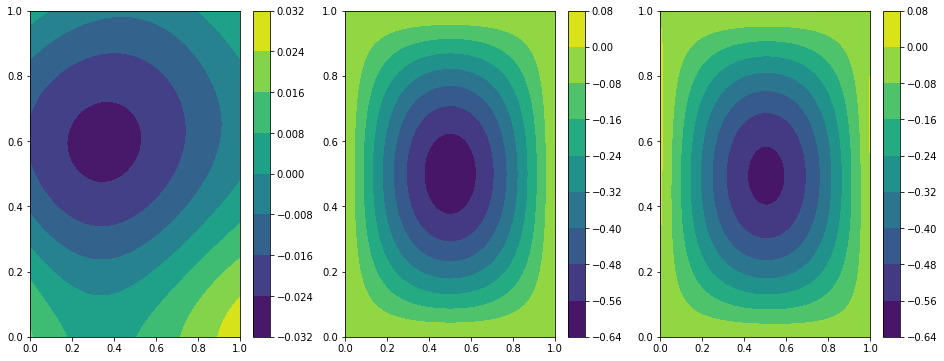

In [7]:
plotter = Plotter()

# plotting at fixed time t = 0.5
plotter.plot(pinn, fixed_variables={'t' : 0.5})


We can also plot the pinn loss during the training to see the decrease.

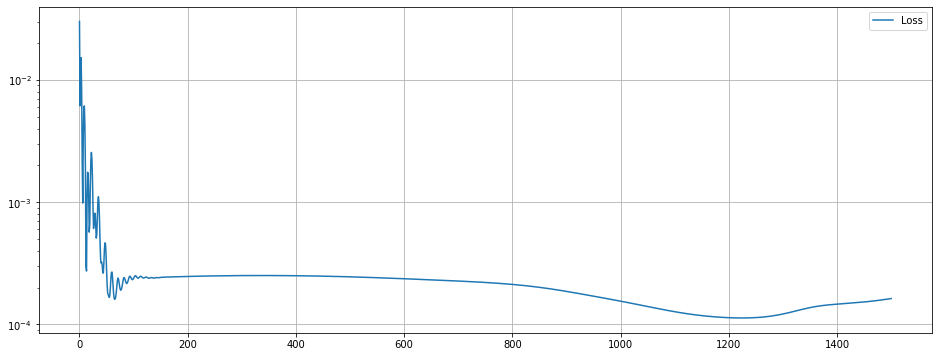

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plotter.plot_loss(pinn, label='Loss')

plt.grid()
plt.legend()
plt.show()